In [2]:
import torch
from matplotlib import pyplot as plt
from PIL import Image
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import numpy as np
import torch.nn.functional as F
from torch_scatter import scatter
from matplotlib import pyplot as plt

from render import myRender

RENDERER = myRender(image_size=1000)

def euler2mat(angle):
    """Convert euler angles to rotation matrix.
     :param angle: [3] or [b, 3]
     :return
        rotmat: [3] or [b, 3, 3]
    source
    https://github.com/ClementPinard/SfmLearner-Pytorch/blob/master/inverse_warp.py
    """

    if len(angle.size()) == 1:
        x, y, z = angle[0], angle[1], angle[2]
        _dim = 0
        _view = [3, 3]
    elif len(angle.size()) == 2:
        b, _ = angle.size()
        x, y, z = angle[:, 0], angle[:, 1], angle[:, 2]
        _dim = 1
        _view = [b, 3, 3]

    else:
        assert False

    cosz = torch.cos(z)
    sinz = torch.sin(z)

    # zero = torch.zeros([b], requires_grad=False, device=angle.device)[0]
    # one = torch.ones([b], requires_grad=False, device=angle.device)[0]
    zero = z.detach()*0
    one = zero.detach()+1
    zmat = torch.stack([cosz, -sinz, zero,
                        sinz, cosz, zero,
                        zero, zero, one], dim=_dim).reshape(_view)

    cosy = torch.cos(y)
    siny = torch.sin(y)

    ymat = torch.stack([cosy, zero, siny,
                        zero, one, zero,
                        -siny, zero, cosy], dim=_dim).reshape(_view)

    cosx = torch.cos(x)
    sinx = torch.sin(x)

    xmat = torch.stack([one, zero, zero,
                        zero, cosx, -sinx,
                        zero, sinx, cosx], dim=_dim).reshape(_view)

    rot_mat = xmat @ ymat @ zmat
    # print(rot_mat)
    return rot_mat


def rotate_angle_vector(theta, v):
    '''
        theta: B 1
        v:  B 3
    '''
    cos_a = torch.cos(theta)
    sin_a = torch.sin(theta)
    x, y, z = v[:, 0:1], v[:, 1:2], v[:, 2:3]
    
    R = torch.stack([
        torch.cat([cos_a+(1-cos_a)*x*x, (1-cos_a)*x*y-sin_a*z, (1-cos_a)*x*z+sin_a*y], dim=-1) , # [b1 b1 b1]
        torch.cat([(1-cos_a)*y*x+sin_a*z, cos_a+(1-cos_a)*y*y, (1-cos_a)*y*z-sin_a*x], dim=-1) ,
        torch.cat([(1-cos_a)*z*x-sin_a*y, (1-cos_a)*z*y+sin_a*x, cos_a+(1-cos_a)*z*z], dim=-1) 
    ], dim = 1)

    return R

def rotate_theta_phi(angles):
    '''
        angles: B, 2
    '''
    assert len(angles.shape) == 2
    B = angles.size(0)
    phi, theta = angles[:, 0:1], angles[:, 1:2]

    v1 = torch.Tensor([[0, 0, 1]]).expand(B, -1) # B 3
    v2 = torch.cat([torch.sin(theta) , -torch.cos(theta), torch.zeros_like(theta)], dim=-1) # B 3

    R1_inv = rotate_angle_vector(-theta, v1)
    R2_inv = rotate_angle_vector(-phi, v2)
    R_inv = R1_inv @ R2_inv

    return R_inv

def rotate_point_clouds_batch(pc, rotation_matrix, use_normals=False):
    '''
        Input: 
            pc  B N 3
            R   B 3 3
        Output:
            B N 3
    '''
    if not use_normals:
        new_pc = torch.einsum('bnc, bdc -> bnd', pc, rotation_matrix.float().to(pc.device))
    else:
        new_pc = torch.einsum('bnc, bdc -> bnd', pc[:, :, :3], rotation_matrix.float().to(pc.device))
        new_normal = torch.einsum('bnc, bdc -> bnd', pc[:, :, 3:], rotation_matrix.float().to(pc.device))
        new_pc = torch.cat([new_pc, new_normal], dim=-1)
    return new_pc

In [3]:
import pickle
split = "train"
# path = f'/remote-home/shicheng/3d/P2P/data/modelnet40_{split}_8192pts_fps.dat'
path = r"/public/home/fengyf2/projects/PointCLIP/PointCLIP/data/modelnet40_2048dat/modelnet40_train_8192pts_fps.dat"
with open(path, 'rb') as f:
    _points, labels = pickle.load(f)

In [4]:
# path = f'/remote-home/shicheng/3d/modelnet_render/modelnet40_{split}_off.dat'
path = 'test_off.dat'
with open(path, "rb") as f:
    render_points = pickle.load(f)
    render_meshes = pickle.load(f)
    point_inds = pickle.load(f)
    mesh_inds = pickle.load(f)

In [5]:
with open("modelnet40_safe_train_path.txt", "r") as f:
    new_l = f.readlines()
with open("modelnet40_train_path.txt", "r") as f:
    old_l = f.readlines()
    
new2old_inds = []
for l in new_l:
    ind = old_l.index(l)
    new2old_inds.append(ind)

In [5]:
obj_name = 'airplane_0001'
with open(f"/remote-home/shicheng/3d/modelnet_render/modelnet40_{split}_path.txt", 'r') as f:
    paths = f.readlines()
    paths = [path.strip() for path in paths]
obj_id = paths.index(obj_name[:-5]+f'/{split}/'+obj_name)
print(obj_id)

# From dat
points = _points[obj_id]
pc = np.array(points)
points_center = (pc.min(axis=0, keepdims=True) + pc.max(axis=0, keepdims=True))/2
_pc = pc[:, :3]
print("\n-- From dat --")
print(_pc.shape)
print(_pc.min(axis=0), _pc.max(axis=0))

# From OFF
ind = point_inds[obj_id]
_render_points = render_points[ind[0]:ind[1]]
ind = mesh_inds[obj_id]
_mesh_points = render_meshes[ind[0]:ind[1]]

print("\n-- From OFF --")
print("render p shape: ", _render_points.shape, "| render m shape: ", _mesh_points.shape)
print(_render_points.min(axis=0), _render_points.max(axis=0))

FileNotFoundError: [Errno 2] No such file or directory: '/remote-home/shicheng/3d/modelnet_render/modelnet40_train_path.txt'

In [6]:
new_ind = 0
old_ind = new2old_inds[new_ind]
print(new_l[new_ind])

points = _points[old_ind]
pc = np.array(points)
points_center = (pc.min(axis=0, keepdims=True) + pc.max(axis=0, keepdims=True))/2
_pc = pc[:, :3]
print("\n-- From dat --")
print(_pc.shape)
print(_pc.min(axis=0), _pc.max(axis=0))

# From OFF
ind = point_inds[new_ind]
_render_points = render_points[ind[0]:ind[1]]
ind = mesh_inds[new_ind]
_mesh_points = render_meshes[ind[0]:ind[1]]

print("\n-- From OFF --")
print("render p shape: ", _render_points.shape, "| render m shape: ", _mesh_points.shape)
print(_render_points.min(axis=0), _render_points.max(axis=0))

airplane/train/airplane_0515


-- From dat --
(8192, 3)
[-0.929  -0.1908 -0.9962] [0.9296 0.3882 0.8576]

-- From OFF --
render p shape:  (376741, 3) | render m shape:  (582949, 3)
[-49.2174 396.481    0.    ] [1689.78  2137.01   541.525]


In [ ]:
length = mesh_inds[:, 1] - mesh_inds[:, 0]
for i in range(len(length)):
    if length[i] > 150000:
        print(i, length[i])

In [ ]:
pc = _pc
pc.max(axis=0, keepdims=True)

In [7]:
THETA_NUM, PHI_NUM = 4, 3
idx = [0,1,2,3,4,5,6,7,8,9,10,11]

rotate_num = len(idx)
theta = np.linspace(0, 1, THETA_NUM)
phi = np.linspace(0, -0.5, PHI_NUM)
theta = np.random.rand(THETA_NUM) * 2 -1
phi = np.random.rand(PHI_NUM) * 2 - 1
angles = torch.zeros((THETA_NUM * PHI_NUM, 3))
t = torch.tensor(np.stack(np.meshgrid(phi, theta, indexing='ij'), axis=-1).reshape(-1, 2))
angles[:, 1] = t[:, 0]
angles[:, 2] = t[:, 1]
angles = angles[idx]
print("Multiview angles:", angles)
rotation_matrixs = euler2mat(angles * np.pi)
rotation_matrixs = rotation_matrixs
_align_matrix1 = euler2mat(torch.tensor([0.5*np.pi, np.pi, 0]))
# _align_matrix2 = euler2mat(torch.tensor([0.3*np.pi, 0.3*np.pi, 0.3*np.pi]))
_align_matrix2 = euler2mat(torch.tensor([0, 0, 0]))
xyz1 = torch.Tensor(np.random.uniform(low=3./4., high=3./4., size=[3]))
xyz2 = torch.Tensor(np.random.uniform(low=-0.2, high=0.2, size=[3]))

# _xyz1 = torch.zeros_like(xyz1)
_xyz1 = torch.take(xyz1, torch.tensor([2, 0, 1]))


# _xyz2 = torch.zeros_like(xyz2)
_xyz2 = torch.take(xyz2, torch.tensor([2, 0, 1]))
# _xyz2[2] = xyz2[0]
# _xyz2[0] = xyz2[1]
# _xyz2[1] = xyz2[2]

print(rotation_matrixs.shape)

Multiview angles: tensor([[ 0.0000, -0.5326, -0.1581],
        [ 0.0000, -0.5326, -0.4835],
        [ 0.0000, -0.5326,  0.8065],
        [ 0.0000, -0.5326, -0.3162],
        [ 0.0000, -0.2820, -0.1581],
        [ 0.0000, -0.2820, -0.4835],
        [ 0.0000, -0.2820,  0.8065],
        [ 0.0000, -0.2820, -0.3162],
        [ 0.0000,  0.4145, -0.1581],
        [ 0.0000,  0.4145, -0.4835],
        [ 0.0000,  0.4145,  0.8065],
        [ 0.0000,  0.4145, -0.3162]])
torch.Size([12, 3, 3])


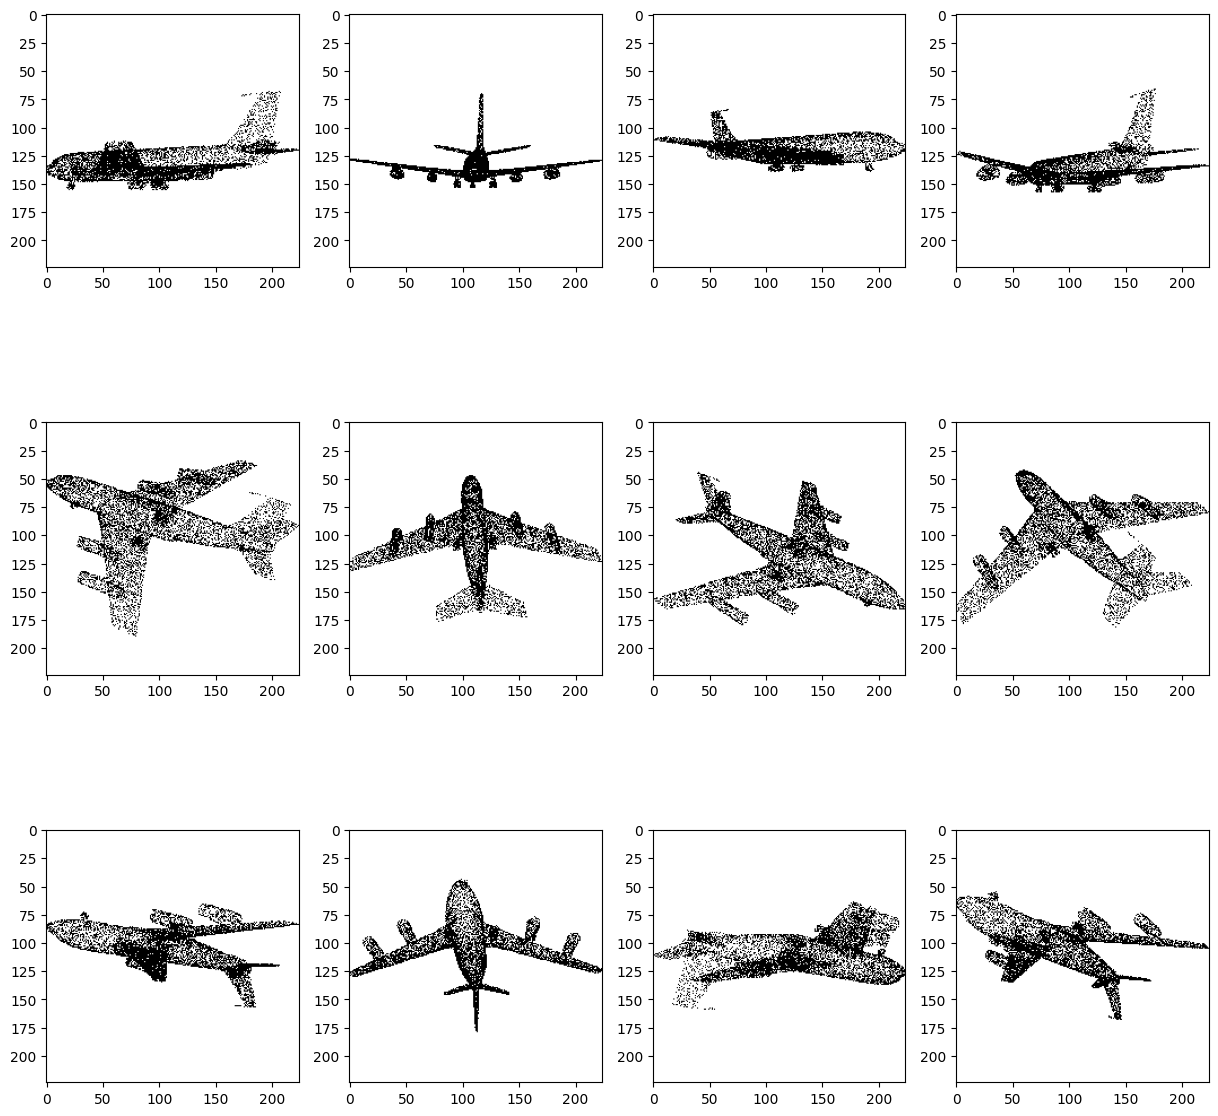

In [8]:
N = _pc.shape[0]
B = 1
obj_size = 224
img_size = 224

pc = torch.tensor(_pc).float().unsqueeze(0)
# pc = pc * xyz1

center = (pc.min(dim=1, keepdim=True)[0] + pc.max(dim=1, keepdim=True)[0]) / 2
pc = pc - center
pc /= pc.max()
pc *= xyz1
pc += xyz2
new_pc = pc.unsqueeze(1).repeat(1, rotate_num, 1, 1).reshape(-1, N, 3) # B*R, N, 3

align_matrix = _align_matrix1.float().to(pc.device) # 3, 3
align_matrix = align_matrix.unsqueeze(0).repeat(B*rotate_num, 1, 1).reshape(-1, 3, 3) # B*R, 3, 3
new_pc = rotate_point_clouds_batch(new_pc, align_matrix) # B*R, N, 3

align_matrix = _align_matrix2.float().to(pc.device) # 3, 3
align_matrix = align_matrix.unsqueeze(0).repeat(B*rotate_num, 1, 1).reshape(-1, 3, 3) # B*R, 3, 3
new_pc = rotate_point_clouds_batch(new_pc, align_matrix) # B*R, N, 3

rotation_matrix = rotation_matrixs.float().to(pc.device) # R, 3, 3
rotation_matrix = rotation_matrix.unsqueeze(0).repeat(B, 1, 1, 1).reshape(-1, 3, 3) # B*R, 3, 3
new_pc = rotate_point_clouds_batch(new_pc, rotation_matrix) # B*R, N, 3

centers = (new_pc.min(dim=1, keepdim=True)[0] + new_pc.max(dim=1, keepdim=True)[0]) / 2
new_pc = new_pc - centers
new_pc = new_pc / new_pc.max()
d = -1.01*new_pc[:, :, 2] + 3
_pc_d = new_pc[:, :, :2] / d.unsqueeze(-1)
n_centers = (_pc_d.min(dim=1, keepdim=True)[0] + _pc_d.max(dim=1, keepdim=True)[0]) / 2
new_pc = _pc_d - n_centers
# new_pc[:, :, :2] = new_pc[:, :, :2] / ((new_pc[:, :, 2] + 2).unsqueeze(-1) * 1)
pc_range = (new_pc.max(dim=1)[0] - new_pc.min(dim=1)[0])[:, :2]  # B*R, 2
grid_size = pc_range.max(dim=-1)[0] / obj_size # B*R
idx_xy = torch.floor(new_pc[:, :, :2] / (grid_size.reshape(-1, 1, 1) + 1e-7))  # B*R, N, 2
assert(idx_xy[:, :, 0].max() - idx_xy[:, :, 0].min() < obj_size)
assert(idx_xy[:, :, 1].max() - idx_xy[:, :, 1].min() < obj_size)

idx_xy = idx_xy.long()
center = img_size // 2
idx_xy = idx_xy + center
assert(idx_xy.max() < obj_size)
assert(idx_xy.min() >= 0)
coord = idx_xy[:, :, 0] * img_size + idx_xy[:, :, 1]  # B*R, N

B = rotate_num
images = torch.zeros(B, img_size*img_size, 1).to(pc.device)
pc_val = torch.ones(B, N, 1).to(pc.device) # B N 1
images = scatter(pc_val, coord.long(), dim=1, out=images, reduce="max")
images = images / images.max(dim=1, keepdim=True)[0]
images = images.reshape(rotate_num, img_size, img_size).contiguous()

plt.figure(figsize=(15, 15))
proj_img_list = []
for r in range(rotate_num):
    plt.subplot(3,4, r+1)
    img = images[r].detach().cpu()
    img = img.unsqueeze(2).repeat(1, 1, 3)
    im = 1-img
    proj_img_list.append(im)
    # im = (img*0.5 + rendered_imgs[r]*0.5).long()
    plt.imshow(im)

In [ ]:
_align_matrix_3 = euler2mat(torch.tensor([0, -0.5*np.pi, 0]))

pc = torch.tensor(_render_points).float()
N = pc.shape[0]
center = (pc.min(dim=0, keepdim=True)[0] + pc.max(dim=0, keepdim=True)[0]) / 2
pc = pc - center
pc /= pc.max()
pc *= _xyz1
pc += _xyz2
new_pc = pc.unsqueeze(0).repeat(rotate_num, 1, 1).reshape(-1, N, 3) # B*R, N, 3

align_matrix = _align_matrix2.float().to(pc.device) # 3, 3
align_matrix = align_matrix.unsqueeze(0).repeat(rotate_num, 1, 1).reshape(-1, 3, 3) # B*R, 3, 3
new_pc = rotate_point_clouds_batch(new_pc, align_matrix) # B*R, N, 3

rotation_matrix = rotation_matrixs.float().to(pc.device) # R, 3, 3
new_pc = rotate_point_clouds_batch(new_pc, rotation_matrix) # B*R, N, 3

center = (new_pc.min(dim=1, keepdim=True)[0] + new_pc.max(dim=1, keepdim=True)[0]) / 2
new_pc = new_pc - center
scale = new_pc.reshape(rotate_num, -1).max(dim=-1)[0]
new_pc = new_pc / scale.unsqueeze(-1).unsqueeze(-1)

faces = torch.tensor(_mesh_points).unsqueeze(0).repeat(rotate_num, 1, 1)

new_pc = new_pc.cuda()
faces = faces.cuda()

with torch.no_grad():
    images = RENDERER.render_meshes(new_pc, faces)

plt.figure(figsize=(15, 15))
for i in range(rotate_num):
    img = images[i].detach().cpu()
    img = img[..., :3]
    _im = img.sum(dim=-1)
    _im = 3 - _im
    pixel_x, pixel_y = torch.nonzero(_im, as_tuple=True)
    max_l = max(pixel_x.max() - pixel_x.min(), pixel_y.max() - pixel_y.min())
    center_x = (pixel_x.max() + pixel_x.min()) / 2
    center_y = (pixel_y.max() + pixel_y.min()) / 2
    img_= img[pixel_x.min():pixel_x.max(),
              pixel_y.min():pixel_y.max()]
    h_,w_,__ = img_.shape
    v_padding = torch.div((max_l - h_), 2, rounding_mode='floor')
    h_padding = torch.div((max_l - w_), 2, rounding_mode='floor')
    img_ = F.pad(img_.permute(2,0,1)[None,...],
                 (h_padding,max_l - w_ - h_padding,v_padding,max_l - h_ - v_padding),
                 mode='constant', value=1)
    
    image = F.interpolate(img_, size=(224,224), mode='bilinear', align_corners=True)
    image = image.squeeze(0).permute(1,2,0)
    
    image = image*0.5 + proj_img_list[i]*0.5
    plt.subplot(3,4, i+1)
    plt.imshow(image)

In [ ]:
N = _pc.shape[0]
B = 1
obj_size = 224
img_size = 224

pc = torch.tensor(_render_points).float().unsqueeze(0)
N = pc.shape[1]
center = (pc.min(dim=1, keepdim=True)[0] + pc.max(dim=1, keepdim=True)[0]) / 2
pc = pc - center
new_pc = pc.unsqueeze(1).repeat(1, rotate_num, 1, 1).reshape(-1, N, 3) # B*R, N, 3

rotation_matrix = rotation_matrixs.float().to(pc.device) # R, 3, 3
rotation_matrix = rotation_matrix.unsqueeze(0).repeat(B, 1, 1, 1).reshape(-1, 3, 3) # B*R, 3, 3
new_pc = rotate_point_clouds_batch(new_pc, rotation_matrix) # B*R, N, 3

centers = (new_pc.min(dim=1, keepdim=True)[0] + new_pc.max(dim=1, keepdim=True)[0]) / 2
new_pc = new_pc - centers
new_pc = new_pc / new_pc.max()
d = -1.0*new_pc[:, :, 2] + 3
_pc_d = new_pc[:, :, :2] / d.unsqueeze(-1)
n_centers = (_pc_d.min(dim=1, keepdim=True)[0] + _pc_d.max(dim=1, keepdim=True)[0]) / 2
new_pc = _pc_d - n_centers
# new_pc[:, :, :2] = new_pc[:, :, :2] / ((new_pc[:, :, 2] + 2).unsqueeze(-1) * 1)
pc_range = (new_pc.max(dim=1)[0] - new_pc.min(dim=1)[0])[:, :2]  # B*R, 2
grid_size = pc_range.max(dim=-1)[0] / obj_size # B*R
idx_xy = torch.floor(new_pc[:, :, :2] / (grid_size.reshape(-1, 1, 1) + 1e-7))  # B*R, N, 2

idx_xy = idx_xy.long()
center = img_size // 2
idx_xy = idx_xy + center
assert(idx_xy.max() < obj_size)
assert(idx_xy.min() >= 0)
coord = idx_xy[:, :, 0] * img_size + idx_xy[:, :, 1]  # B*R, N

B = rotate_num
images = torch.zeros(B, img_size*img_size, 1).to(pc.device)
pc_val = torch.ones(B, N, 1).to(pc.device) # B N 1
images = scatter(pc_val, coord.long(), dim=1, out=images, reduce="max")
images = images / images.max(dim=1, keepdim=True)[0]
images = images.reshape(rotate_num, img_size, img_size).contiguous()

plt.figure(figsize=(15, 15))
proj_img_list = []
for r in range(rotate_num):
    plt.subplot(3,4, r+1)
    img = images[r].detach().cpu()
    img = img.unsqueeze(2).repeat(1, 1, 3)
    im = 1-img
    proj_img_list.append(im)
    # im = (img*0.5 + rendered_imgs[r]*0.5).long()
    plt.imshow(im)

In [ ]:
im = RENDERER.render_meshes(new_pc[0].unsqueeze(0), faces[0].unsqueeze(0))
len(im.shape)

In [ ]:
t = torch.Tensor([1,2]).cuda()